## Project Milestone 3

### 1) Load the data, clean it again before starting to work. 

In [1]:
# Some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import ast
import re
import seaborn as sns 

In [2]:
# load the data 
ethnicity_df_path = 'data/processed_data/diversity_final.csv'
sucess_movies_df_path = 'data/processed_data/success_movies_df.csv'
ethnicity_df = pd.read_csv(ethnicity_df_path)
sucess_movies_df = pd.read_csv(sucess_movies_df_path)

In [3]:
# visualize the dataframe
ethnicity_df.head()
sucess_movies_df.head()

,Movie_name,Movie_release_date,Ratings,Wikipedia_movie_ID,Actor_ethnicity,Movie_countries,Movie_box_office_revenue,Nomination,Success
0,$,1971,6.3,4213160.0,Hungarian Americans,{'United States of America'},NaN,False,0
1,$9.99,2008,6.7,20624798.0,Australians,"{'Australia', 'Israel'}",NaN,False,0
2,'R Xmas,2001,5.7,24799628.0,Italian Americans,"{'France', 'United States of America'}",NaN,False,0
3,'Til There Was You,1997,4.8,17841580.0,Irish Americans,{'United States of America'},NaN,False,0
4,'Til We Meet Again,1940,6.7,16038391.0,Irish Americans,{'United States of America'},NaN,False,0


In [4]:
#merge the two dataframes
ethnicity_sucess= pd.merge(ethnicity_df,sucess_movies_df,on=['Wikipedia_movie_ID'],how='inner')

In [5]:
# for now let's drop the lines where we don't have a diversity score. 
ethnicity_sucess_df=ethnicity_sucess.dropna(subset=['diversity'])

### 2) Explore the data, get to know the data

What is the distribution of our diversity score? question is it normal that diversity score goes up to 2.5 or is it supposed to be between 0 and 1?

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_826/1076679750.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


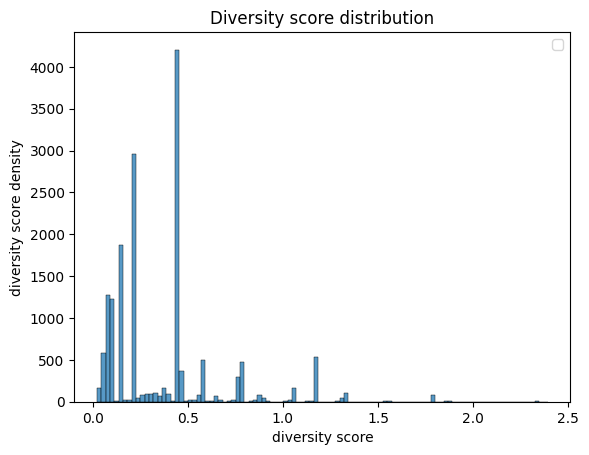

In [6]:
# plot histogram of the distribution of diversity scores
ax= sns.histplot(ethnicity_sucess_df['diversity'])
ax.set(title='Diversity score distribution',xlabel='diversity score', ylabel='diversity score density')
plt.legend()
plt.show()

In [7]:
import plotly.express as px
fig = px.histogram(ethnicity_sucess_df['diversity'], x="diversity")
fig.show()

In [8]:
# basic statistics
ethnicity_sucess_df.diversity.describe()

count    16134.000000
mean         0.365256
std          0.305333
min          0.022858
25%          0.144765
50%          0.217147
75%          0.434294
max          2.392035
Name: diversity, dtype: float64

How does the diversity score evolves over time? 

/var/folders/w7/t9sglxkj5nz7xv4mxk5dftlh0000gn/T/ipykernel_826/1337128289.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Text(0, 0.5, 'Diversity Score')

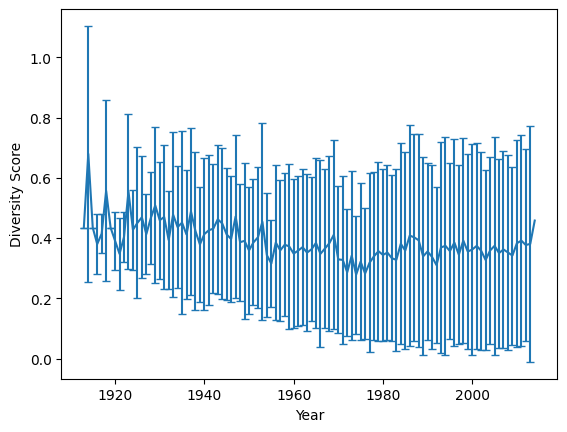

In [9]:
diversity_by_year = ethnicity_sucess_df.groupby(ethnicity_sucess_df['Movie_release_date']).apply(lambda x: pd.Series({
        'average_diversity': x['diversity'].mean(),
        'std_diversity': x['diversity'].std()
    }))	

plt.errorbar(diversity_by_year.index, diversity_by_year.average_diversity,
             yerr = diversity_by_year.std_diversity,
             capsize= 3)
plt.xlabel('Year')
plt.ylabel('Diversity Score')

Je sais pas trop quoi en penser. J'ai l'impression il y a pas clairement d'évolution du score et surtout des incertitudes juste énormes. 

### 3) Hypothesis testing

Is diversity higher in sucessful movies compared to less successful movies ?

In [10]:
ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'].mean()

np.float64(0.33226197858797096)

In [11]:
ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'].mean()

np.float64(0.36933721773227834)

the diversity factor seems slightly higher for less successful films than for successful films. 

Is this difference significant?  Let's do a t-test.

In [12]:
from statsmodels.stats import diagnostic
from scipy import stats
import seaborn as sns

In [13]:
stats.ttest_ind(ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 1]['diversity'], ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'] == 0]['diversity'])

TtestResult(statistic=np.float64(-4.830679292625512), pvalue=np.float64(1.3731766127325955e-06), df=np.float64(16132.0))

the p-value is 0.00000137; smaller than 0.05. therefore we can reject the null hypothesis that the diversity accross the sucessful and less succesful movies is the same. There is a significant difference. 

(0.0, 1.0)

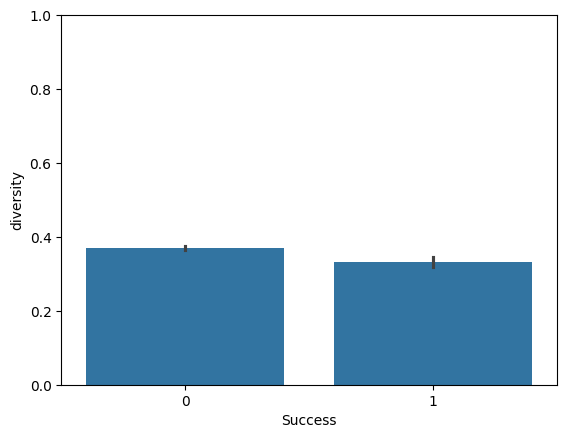

In [14]:
ax = sns.barplot(x="Success", y="diversity", data=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'].isin([0,1])])
plt.ylim([0,1])

### 4) Examining relationship between two variables 

In [15]:
stats.pearsonr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Success'])

PearsonRResult(statistic=np.float64(-0.03800582948315366), pvalue=np.float64(1.3731766127326519e-06))

Correlation significant. Weak negative association. More diversity - less success. 

In [16]:
stats.spearmanr(ethnicity_sucess_df['diversity'],ethnicity_sucess_df['Success'])

SignificanceResult(statistic=np.float64(-0.037460669446335415), pvalue=np.float64(1.9403065609731955e-06))

Correlation significant. Weak negative association. More diversity- less success. 

### 5) Propensity score matching. 

Many confounders can influence the success of a film. Let's try to isolate the effect of diversity on the sucess of a film. Treatment is diversity. Considered as treated if the diversity score is superior to 0.365256. control if the diversity score is inferior to 0.365256. 

In [17]:
treated = ethnicity_sucess_df.loc[ethnicity_sucess_df['diversity'] >= 0.365256] 
control = ethnicity_sucess_df.loc[ethnicity_sucess_df['diversity'] <= 0.365256]

In [18]:
treated.Movie_box_office_revenue.describe()

count    7.510000e+02
mean     4.643275e+07
std      1.010380e+08
min      1.185900e+04
25%      2.096902e+06
50%      1.108757e+07
75%      3.843955e+07
max      9.260471e+08
Name: Movie_box_office_revenue, dtype: float64

In [19]:
control.Movie_box_office_revenue.describe()

count    8.240000e+02
mean     4.933969e+07
std      1.051718e+08
min      1.123800e+04
25%      1.993750e+06
50%      9.350978e+06
75%      4.018891e+07
max      8.866868e+08
Name: Movie_box_office_revenue, dtype: float64

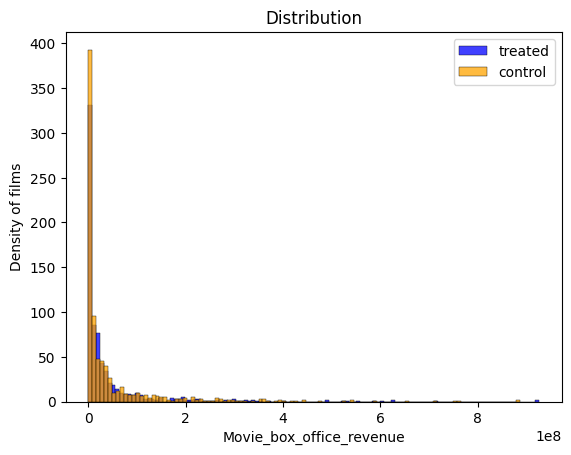

In [20]:
ax = sns.histplot(treated['Movie_box_office_revenue'], color='blue', label='treated')
ax = sns.histplot(control['Movie_box_office_revenue'], color='orange', label='control')
ax.set(title='Distribution',xlabel='Movie_box_office_revenue', ylabel='Density of films')
plt.legend()
plt.show()

Il faut aller rechercher des colonnes dans le dataset de base:"Movie_runtime","Movie_languages","Movie_countries","Movie_genres" pour faire des paires de films similaires. 

In [21]:
movie_metadata_path = 'data/raw_data/movie.metadata.tsv'
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t')

In [22]:
new_column_names_m = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages",
    "Movie_countries",
    "Movie_genres"
]

# Rename the columns by directly setting DataFrame.columns
movie_metadata.columns = new_column_names_m

In [23]:
# Remaining rows:
columns_to_check = ['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']
remaining_rows = {col: movie_metadata[col].dropna().shape[0] for col in columns_to_check}
# Print the results
for col, count in remaining_rows.items():
    print(f"Remaining rows for '{col}': {count}")

# Drop the rows where na
filtered_movie = movie_metadata[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Wikipedia_movie_ID'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_name'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_release_date'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_countries'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_runtime'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_languages'])
filtered_movie = filtered_movie[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_runtime', 'Movie_languages',
    'Movie_countries', 'Movie_genres']].dropna(subset=['Movie_genres'])
# Display the updated DataFrame
display(filtered_movie)

Remaining rows for 'Wikipedia_movie_ID': 81740
Remaining rows for 'Movie_name': 81740
Remaining rows for 'Movie_release_date': 74838
Remaining rows for 'Movie_runtime': 61290
Remaining rows for 'Movie_languages': 81740
Remaining rows for 'Movie_countries': 81740
Remaining rows for 'Movie_genres': 81740


,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,The Gangsters,1913-05-29,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011-03-19,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81736,34980460,Knuckle,2011-01-21,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81737,9971909,Another Nice Mess,1972-09-22,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [24]:
# Convert strings to dictionaries
filtered_movie['Movie_countries'] = filtered_movie['Movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_countries'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_countries'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261

# Convert strings to dictionaries
filtered_movie['Movie_genres'] = filtered_movie['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_genres'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_genres'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261

# Convert strings to dictionaries
filtered_movie['Movie_languages'] = filtered_movie['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now count the empty dictionaries
empty_dict_count = filtered_movie['Movie_languages'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()
print(f"Number of empty dictionaries: {empty_dict_count}") # 139

# Need to drop the row where the country is not known (empty dictionnary)
filtered_movie = filtered_movie[filtered_movie['Movie_languages'].apply(lambda x: isinstance(x, dict) and len(x) > 0)] # 8261



Number of empty dictionaries: 2560
Number of empty dictionaries: 347
Number of empty dictionaries: 4840


In [25]:
# Clean country column with only the names of the countries

# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_countries'] = filtered_movie['Movie_countries'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_genres'] = filtered_movie['Movie_genres'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
# Extract only the country names and store them as a set
filtered_movie.loc[:, 'Movie_languages'] = filtered_movie['Movie_languages'].apply(
    lambda x: set(x.values()) if isinstance(x, dict) else set()
)
display(filtered_movie)

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,{English Language},{United States of America},"{Biographical film, Crime Drama, Drama, Mystery}"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Thriller, Erotic thri..."
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama}
4,13696889,The Gangsters,1913-05-29,35.0,"{Silent film, English Language}",{United States of America},"{Indie, Black-and-white, Comedy, Silent film, ..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011-03-19,120.0,{English Language},{United States of America},{Drama}
81736,34980460,Knuckle,2011-01-21,96.0,{English Language},"{Ireland, United Kingdom}","{Biographical film, Drama, Documentary}"
81737,9971909,Another Nice Mess,1972-09-22,66.0,{English Language},{United States of America},"{Satire, Comedy}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,{Japanese Language},{Japan},"{Anime, Science Fiction, Adventure, Short Film..."


In [26]:
# Now we clean release date:
# (as we see that there is several ways to write the date and that there are missing values)

# We need to clean release date (as we see that there is several ways to write the date)
filtered_movie.loc[:,'Movie_release_date'] = filtered_movie['Movie_release_date'].astype(str).str[:4]

# Display the updated DataFrame
display(filtered_movie)

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,{English Language},{United States of America},"{Biographical film, Crime Drama, Drama, Mystery}"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Thriller, Erotic thri..."
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama}
4,13696889,The Gangsters,1913,35.0,"{Silent film, English Language}",{United States of America},"{Indie, Black-and-white, Comedy, Silent film, ..."
...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011,120.0,{English Language},{United States of America},{Drama}
81736,34980460,Knuckle,2011,96.0,{English Language},"{Ireland, United Kingdom}","{Biographical film, Drama, Documentary}"
81737,9971909,Another Nice Mess,1972,66.0,{English Language},{United States of America},"{Satire, Comedy}"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992,150.0,{Japanese Language},{Japan},"{Anime, Science Fiction, Adventure, Short Film..."


In [27]:
# Now we clean movie names
# It appears that the same movie name can appear several time

# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_countries_str'] = filtered_movie['Movie_countries'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))
# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_languages_str'] = filtered_movie['Movie_languages'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))

# Convert 'Movie_countries' to a string representation for grouping
filtered_movie.loc[:,'Movie_genres_str'] = filtered_movie['Movie_genres'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, set) else str(x))
filtered_movie

,Wikipedia_movie_ID,Movie_name,Movie_release_date,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_countries_str,Movie_languages_str,Movie_genres_str
0,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,95.0,{English Language},{United States of America},"{Biographical film, Crime Drama, Drama, Mystery}",United States of America,English Language,"Biographical film, Crime Drama, Drama, Mystery"
1,28463795,Brun bitter,1988,83.0,{Norwegian Language},{Norway},"{Crime Fiction, Drama}",Norway,Norwegian Language,"Crime Fiction, Drama"
2,9363483,White Of The Eye,1987,110.0,{English Language},{United Kingdom},"{Psychological thriller, Thriller, Erotic thri...",United Kingdom,English Language,"Erotic thriller, Psychological thriller, Thriller"
3,261236,A Woman in Flames,1983,106.0,{German Language},{Germany},{Drama},Germany,German Language,Drama
4,13696889,The Gangsters,1913,35.0,"{Silent film, English Language}",{United States of America},"{Indie, Black-and-white, Comedy, Silent film, ...",United States of America,"English Language, Silent film","Black-and-white, Comedy, Indie, Short Film, Si..."
...,...,...,...,...,...,...,...,...,...,...
81735,35228177,Mermaids: The Body Found,2011,120.0,{English Language},{United States of America},{Drama},United States of America,English Language,Drama
81736,34980460,Knuckle,2011,96.0,{English Language},"{Ireland, United Kingdom}","{Biographical film, Drama, Documentary}","Ireland, United Kingdom",English Language,"Biographical film, Documentary, Drama"
81737,9971909,Another Nice Mess,1972,66.0,{English Language},{United States of America},"{Satire, Comedy}",United States of America,English Language,"Comedy, Satire"
81738,913762,The Super Dimension Fortress Macross II: Lover...,1992,150.0,{Japanese Language},{Japan},"{Anime, Science Fiction, Adventure, Short Film...",Japan,Japanese Language,"Adventure, Animation, Anime, Drama, Japanese M..."


In [28]:
# Group by 'Movie_name', 'Wikipedia_movie_ID', 'Movie_release_date', and 'Movie_countries_str'
merged_filtered_movie_test = (
    filtered_movie.groupby(['Movie_name', 'Wikipedia_movie_ID', 'Movie_release_date', 'Movie_runtime','Movie_countries_str','Movie_languages_str','Movie_genres_str'], as_index=False)
    .agg({'Movie_countries_str': 'first'})  # Retain the merged string representation
)

# Rename the column back to 'Movie_countries' for consistency
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_countries_str': 'Movie_countries'})
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_languages_str': 'Movie_languages'})
merged_filtered_movie_test = merged_filtered_movie_test.rename(columns={'Movie_genres_str': 'Movie_genres'})
# Display the cleaned DataFrame
display(merged_filtered_movie_test)

,Movie_name,Wikipedia_movie_ID,Movie_release_date,Movie_runtime,Movie_languages,Movie_genres,Movie_countries
0,!Women Art Revolution,29988427,2010,83.0,English Language,"Documentary, History, LGBT","Canada, United States of America"
1,$,4213160,1971,119.0,English Language,"Action, Action/Adventure, Comedy, Crime Fictio...",United States of America
2,$9.99,20624798,2008,78.0,English Language,"Animation, Drama, Indie, Stop motion, World ci...","Australia, Israel"
3,'68,2250713,1988,98.0,English Language,"Coming of age, Drama, Family Drama, Period piece","Hungary, United States of America"
4,'Gator Bait,10331139,1974,91.0,English Language,"Action, Drama, Thriller",United States of America
...,...,...,...,...,...,...,...
50878,Žižek!,11033063,2005,71.0,English Language,"Biography, Culture & Society, Documentary, Med...","Canada, United States of America"
50879,Вчера,6077443,1988,84.0,Bulgarian Language,Drama,Bulgaria
50880,…All the Marbles,12680019,1981,113.0,English Language,"Comedy, Comedy-drama, Drama",United States of America
50881,…men Olsenbanden var ikke død,8277007,1984,89.0,Norwegian Language,"Comedy, Crime Fiction",Norway


In [29]:
# simplication, à faire mieux, je garde que le premier pays, genre et langue. 
#merged_filtered_movie_test['Movie_countries'] = merged_filtered_movie_test['Movie_countries'].str.extract(r'([^,]+)')
#merged_filtered_movie_test['Movie_genres'] = merged_filtered_movie_test['Movie_genres'].str.extract(r'([^,]+)')
#merged_filtered_movie_test['Movie_languages'] = merged_filtered_movie_test['Movie_languages'].str.split().str[0]
#ethnicity_sucess_df= ethnicity_sucess_df.drop('Movie_countries', axis=1)

In [30]:
data=pd.merge(merged_filtered_movie_test,ethnicity_sucess_df, on= ['Wikipedia_movie_ID','Movie_name'], how='inner')
data.head()

,Movie_name,Wikipedia_movie_ID,Movie_release_date_x,Movie_runtime,Movie_languages,Movie_genres,Movie_countries_x,ethnicity_number,actor_number,naive_diversity,normalised_entropy,diversity,Movie_release_date_y,Ratings,Actor_ethnicity,Movie_countries_y,Movie_box_office_revenue,Nomination,Success
0,'R Xmas,24799628,2001,83.0,"English Language, Spanish Language","Crime Fiction, Crime Thriller, Drama, Indie, T...","France, United States of America",2,4,0.500000,1.169619,0.584809,2001,5.7,Italian Americans,"{'France', 'United States of America'}",NaN,False,0
1,'Til There Was You,17841580,1997,114.0,English Language,"Comedy, Romance Film, Romantic comedy",United States of America,2,7,0.285714,1.112808,0.317945,1997,4.8,Irish Americans,{'United States of America'},NaN,False,0
2,'Til We Meet Again,16038391,1940,99.0,"English Language, French Language, German Lang...","Black-and-white, Drama, Melodrama, Romance Film",United States of America,2,2,1.000000,1.169619,1.169619,1940,6.7,Irish Americans,{'United States of America'},NaN,False,0
3,*batteries not included,3762449,1987,107.0,English Language,"Comedy, Comedy-drama, Drama, Family Film, Fant...",United States of America,1,2,0.500000,0.434294,0.217147,1987,6.6,African Americans,{'United States of America'},NaN,False,0
4,1 a Minute,24863901,2010,90.0,English Language,Documentary,United States of America,3,8,0.375000,1.715581,0.643343,2010,6.3,Welsh people,{'United States of America'},NaN,False,0


In [31]:
data= data.drop(['Wikipedia_movie_ID','ethnicity_number','actor_number','naive_diversity','normalised_entropy', 'Movie_release_date_y', 'Ratings','Actor_ethnicity','Movie_box_office_revenue',	'Nomination'], axis=1)

In [32]:
data= data.drop(['Movie_countries_y'], axis=1)

In [33]:
data= data.drop(['Movie_genres'], axis=1)

In [34]:
data.sample(10)

,Movie_name,Movie_release_date_x,Movie_runtime,Movie_languages,Movie_countries_x,diversity,Success
2417,Convicts 4,1962,105.0,English Language,United States of America,0.217147,0
3845,Friends with Benefits,2011,109.0,English Language,United States of America,0.062042,0
11199,The Milky Way,1969,105.0,French Language,"France, Germany, Italy, Spain, West Germany",0.434294,0
11773,The Spitfire Grill,1996,116.0,English Language,United States of America,0.434294,0
4540,High Crimes,2002,115.0,"English Language, Spanish Language",United States of America,0.458009,0
7987,Q&A,1990,132.0,English Language,United States of America,0.086859,0
688,American Dreamer,1984,105.0,English Language,United States of America,0.434294,0
5997,Lonelyhearts,1958,103.0,English Language,United States of America,1.169619,0
4866,I'm Losing You,1998,81.0,English Language,United States of America,0.108574,0
7996,Quartet,1981,101.0,"English Language, French Language","France, United Kingdom",0.779746,0


In [35]:
def count_countries(countries_str):
    # Séparer les pays en fonction de la virgule et compter le nombre de pays
    countries = countries_str.split(',')  # Split par la virgule
    return len(countries)

# Appliquer la fonction à la colonne 'Movie_countries_x'
data['Number_of_countries'] = data['Movie_countries_x'].apply(count_countries)

data.sample(30)

,Movie_name,Movie_release_date_x,Movie_runtime,Movie_languages,Movie_countries_x,diversity,Success,Number_of_countries
6701,Mortal Thoughts,1991,102.0,English Language,United States of America,0.144765,0,1
10456,The Family Stone,2005,104.0,English Language,United States of America,1.029348,0,1
4354,Hardware,1990,93.0,English Language,"United Kingdom, United States of America",0.217147,0,2
4694,House II: The Second Story,1987,88.0,English Language,United States of America,0.434294,0,1
9734,Ted Bundy,2002,100.0,English Language,"United Kingdom, United States of America",1.169619,0,2
13166,Woman Obsessed,1959,103.0,English Language,United States of America,0.217147,0,1
11149,The Manchurian Candidate,2004,130.0,English Language,United States of America,0.503898,0,1
11714,The Silence,1963,95.0,Swedish Language,Sweden,0.434294,1,1
13116,Will Success Spoil Rock Hunter?,1957,90.0,English Language,United States of America,0.434294,0,1
873,Antonieta,1982,104.0,Spanish Language,"France, Mexico, Spain",0.434294,0,3


In [36]:
def count_languages(languages_str):
    # Séparer les pays en fonction de la virgule et compter le nombre de pays
    languages = languages_str.split(',')  # Split par la virgule
    return len(languages)

# Appliquer la fonction à la colonne 'Movie_countries_x'
data['Number_of_languages'] = data['Movie_languages'].apply(count_languages)

data.sample(10)

,Movie_name,Movie_release_date_x,Movie_runtime,Movie_languages,Movie_countries_x,diversity,Success,Number_of_countries,Number_of_languages
7152,No Shame,2001,116.0,Spanish Language,Spain,0.144765,0,1,1
8596,Saroja,2008,146.0,"Tamil Language, Telugu language",India,0.072382,0,1,2
3244,Eddie,1996,100.0,English Language,United States of America,0.515382,0,1,1
12308,Times Square,1980,111.0,English Language,United States of America,0.217147,0,1,1
9446,Strippers vs Werewolves,2012,93.0,English Language,United Kingdom,0.144765,0,1,1
11802,The Story of Marie and Julien,2003,150.0,French Language,"France, Italy",1.169619,0,2,1
2139,Chhoti Bahen,1959,171.0,Hindi Language,India,0.144765,0,1,1
9075,Smiley Face,2007,88.0,English Language,"Germany, United States of America",1.157868,0,2,1
2756,Death of a Gunfighter,1969,94.0,English Language,United States of America,1.169619,0,1,1
69,3 Strikes,2000,83.0,English Language,United States of America,0.043429,0,1,1


In [37]:
data['diversity'] = data['diversity'].apply(lambda x: 1 if x >= 0.365256 else x) # treated
data['diversity'] = data['diversity'].apply(lambda x: 0 if x <= 0.365256 else x) # control

In [38]:
data['Movie_release_date_x'] = np.float64(data['Movie_release_date_x'])

In [39]:
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [40]:
# let's standardize the continuous features
data['Movie_release_date_x'] = (data['Movie_release_date_x'] - data['Movie_release_date_x'].mean())/data['Movie_release_date_x'].std()
data['Movie_runtime'] = (data['Movie_runtime'] - data['Movie_runtime'].mean())/data['Movie_runtime'].std()
data['Number_of_countries'] = (data['Number_of_countries'] - data['Number_of_countries'].mean())/data['Number_of_countries'].std()
data['Number_of_languages'] = (data['Number_of_languages'] - data['Number_of_languages'].mean())/data['Number_of_languages'].std()

mod = smf.logit(formula= 'diversity ~  Movie_release_date_x + Movie_runtime + Number_of_countries + Number_of_languages' , data=data)
res = mod.fit()

# Extract the estimated propensity scores
data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.645177
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              diversity   No. Observations:                13351
Model:                          Logit   Df Residuals:                    13346
Method:                           MLE   Df Model:                            4
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.06878
Time:                        08:06:57   Log-Likelihood:                -8613.8
converged:                       True   LL-Null:                       -9250.0
Covariance Type:            nonrobust   LLR p-value:                3.238e-274
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0755      0.018     -4.134      0.000      -0.111      -0.040

In [41]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [ ]:
# Separate the treatment and control groups
treatment_df = data[data['diversity'] == 1]
control_df = data[data['diversity'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [ ]:
balanced_df_1 = data.iloc[matched]

### 6) Try code a good representation for the success threshold. 

(0.0, 1.0)

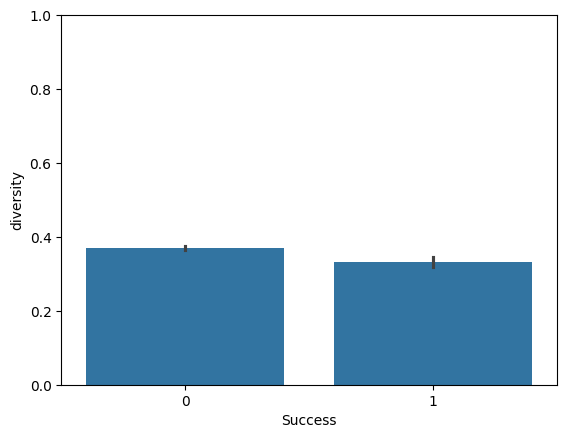

In [ ]:
ax = sns.barplot(x="Success", y="diversity", data=ethnicity_sucess_df.loc[ethnicity_sucess_df['Success'].isin([0,1])])
plt.ylim([0,1])